# Importing Module and define directories

In [1]:
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import time
import matplotlib.pyplot as plt
from MLP import MLP

# Train - Validation Split

In [2]:
data=np.loadtxt("../../data/TR.csv",delimiter=",")
input_data=data[:,1:-2][0:1000]
labels=data[:,-2:][0:1000]
val_data=data[:,1:-2][1000:-1]
val_labels=data[:,-2:][1000:-1]

# Define the MLP

In [3]:
structure=[10,8,20,np.shape(labels)[1]]
act_func=[("sigmoid",1),("sigmoid",1),("sigmoid",1),("linear",1)]
start=[0.001,0.05,0.05,0.01]
learning_rate=5e-5
lamb=1e-4
netw = MLP(structure, func=act_func,
           starting_points=start, 
           eta = learning_rate, lamb = lamb)



## Train the model

In [4]:
N_epoch = 300
netw.train(input_data, labels, val_data, val_labels, epoch = N_epoch)

Epoch 300: --- [train MEE = 3.1709] --- [val MEE = 3.0540]                                   
Elapsed time: 5.55846905708313 s


### And... retrain the model!

In [5]:
netw.train(input_data, labels, val_data, val_labels, epoch = 300)

Epoch 600: --- [train MEE = 2.8289] --- [val MEE = 2.7637]                                  
Elapsed time: 5.554455995559692 s


## Predict the output

In [21]:
train_pred = netw.predict(input_data)
val_pred = netw.predict(val_data)

# Plot results

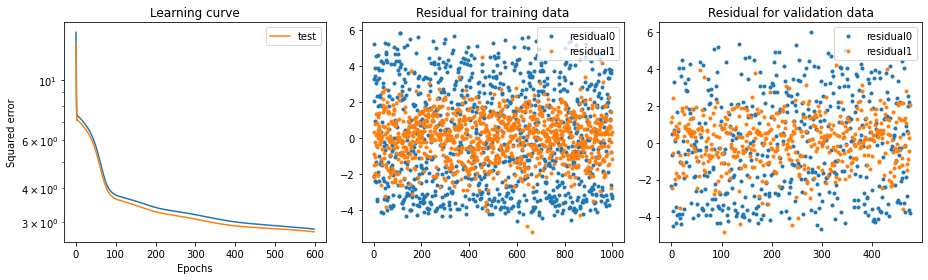

In [22]:
x = np.arange(len(netw.train_MEE))

fig = plt.figure(figsize=(13,4))

fig.add_subplot(131)
plt.plot(x,netw.train_MEE)
plt.plot(x,netw.val_MEE,label="test")
plt.title("Learning curve")
plt.xlabel("Epochs")
plt.ylabel("Squared error")
plt.yscale("log")
plt.legend()

fig.add_subplot(132)
plt.title('Residual for training data')
plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
plt.legend()

fig.add_subplot(133)
plt.title('Residual for validation data')
plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
plt.legend()
plt.tight_layout()
plt.show()